In [19]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Reload uamocf submodules to pick up any changes
import uamocf.models
import uamocf.visualization
importlib.reload(uamocf.models)
importlib.reload(uamocf.visualization)
import uamocf
importlib.reload(uamocf)

# Import from uamocf package
from uamocf import (
    # Data generation
    DataConfig,
    sample_dataset,
    
    # Models
    SimpleNN,
    EnsembleModel,
    
    # Training
    TrainConfig,
    train_ensemble,
    
    # Counterfactual problem
    CFConfig,
    make_cf_problem,
    
    # Optimization
    NSGAConfig,
    run_nsga2,
    
    # Uncertainty
    compute_uncertainty_decomposition,
    
    # Visualization
    plot_proba,
    plot_uncertainty_heatmap,
    plot_pareto_front_2d,
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Generation

We'll generate a 2D classification dataset using the moon-shaped probability surface, which creates interesting decision boundaries with varying uncertainty regions.

In [20]:
# Configure data generation
data_config = DataConfig(
    n=1000,           # Number of samples
    d=2,              # 2D feature space
    n_classes=2,      # Binary classification
    p_fn_name="moon", # Moon-shaped probability surface
)

# Generate data
X, y, probs = sample_dataset(data_config)

print(f"Generated {len(X)} samples")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature ranges: X1=[{X[:,0].min():.2f}, {X[:,0].max():.2f}], X2=[{X[:,1].min():.2f}, {X[:,1].max():.2f}]")

Generated 1000 samples
Class distribution: [517 483]
Feature ranges: X1=[-1.00, 1.00], X2=[-1.00, 1.00]


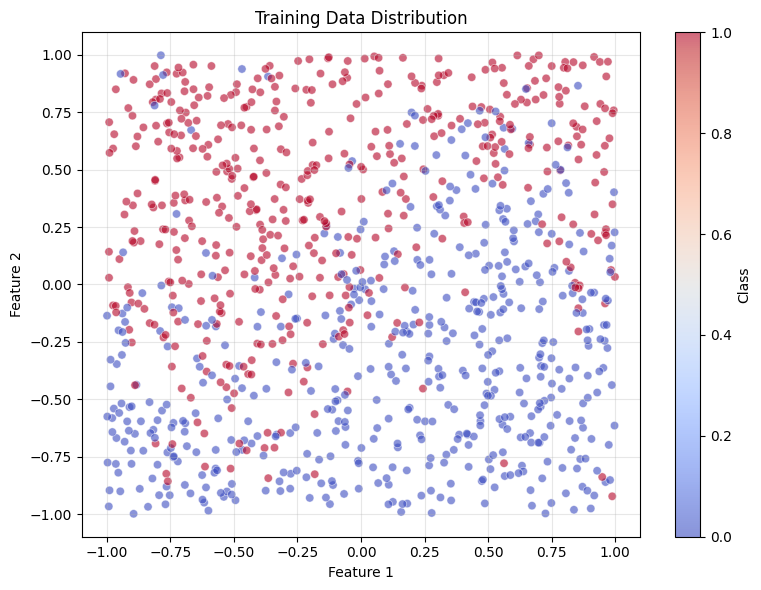

In [21]:
# Visualize the dataset
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='white', linewidth=0.5)
plt.colorbar(scatter, ax=ax, label='Class')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Training Data Distribution')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Train Ensemble Model

We train an ensemble of 5 neural networks. Each model in the ensemble captures slightly different aspects of the data, allowing us to estimate epistemic uncertainty through prediction disagreement.

In [22]:
# Configure training
train_config = TrainConfig(
    epochs=50,
    lr=0.01,
    batch_size=32,
)

# Train ensemble of 5 models
print("Training ensemble...")
train_results = train_ensemble(
    num_models=5,
    X=X,
    y=y,
    cfg=train_config,
    model_factory=lambda: SimpleNN(input_dim=2, hidden_dim=64, output_dim=2),
)

# Create ensemble from trained models
ensemble = EnsembleModel([r.model for r in train_results])

print(f"\n✓ Ensemble trained with {len(ensemble.models)} models")
print(f"  Average validation accuracy: {np.mean([r.val_accuracy for r in train_results]):.2%}")

Training ensemble...

--- Training Model 1/5 ---


Training: 100%|███████████| 50/50 [00:04<00:00, 11.37epoch/s, Train Loss=0.3654]


  Val Accuracy: 81.50%

--- Training Model 2/5 ---


Training: 100%|███████████| 50/50 [00:03<00:00, 12.87epoch/s, Train Loss=0.3675]


  Val Accuracy: 84.00%

--- Training Model 3/5 ---


Training: 100%|███████████| 50/50 [00:04<00:00, 11.51epoch/s, Train Loss=0.3969]


  Val Accuracy: 83.50%

--- Training Model 4/5 ---


Training: 100%|███████████| 50/50 [00:04<00:00, 11.60epoch/s, Train Loss=0.3581]


  Val Accuracy: 81.00%

--- Training Model 5/5 ---


Training: 100%|███████████| 50/50 [00:04<00:00, 11.97epoch/s, Train Loss=0.3734]

  Val Accuracy: 80.50%

✓ Ensemble trained with 5 models
  Average validation accuracy: 82.10%


## 3. Visualize Decision Boundary and Uncertainty

Let's visualize the learned decision boundary and the uncertainty landscape. The epistemic uncertainty is highest in regions where the models disagree.

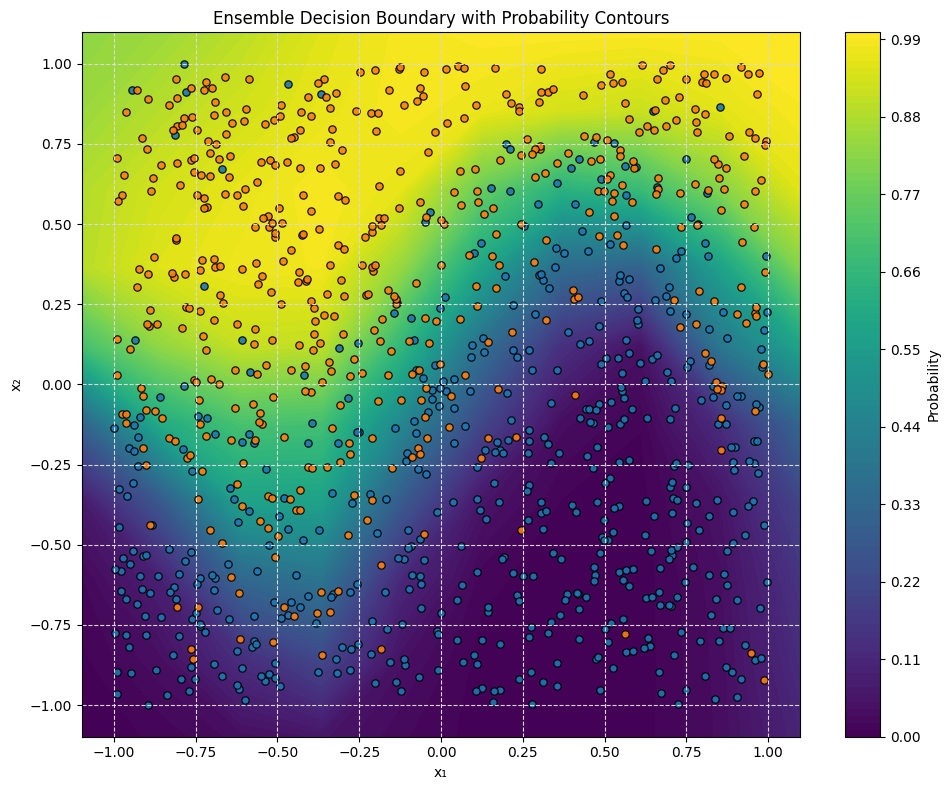

In [23]:
# Plot decision boundary
fig, ax = plt.subplots(figsize=(10, 8))
plot_proba(ensemble, X, y, grid_resolution=10, ax=ax, device=device)
ax.set_title('Ensemble Decision Boundary with Probability Contours')
plt.tight_layout()
plt.show()

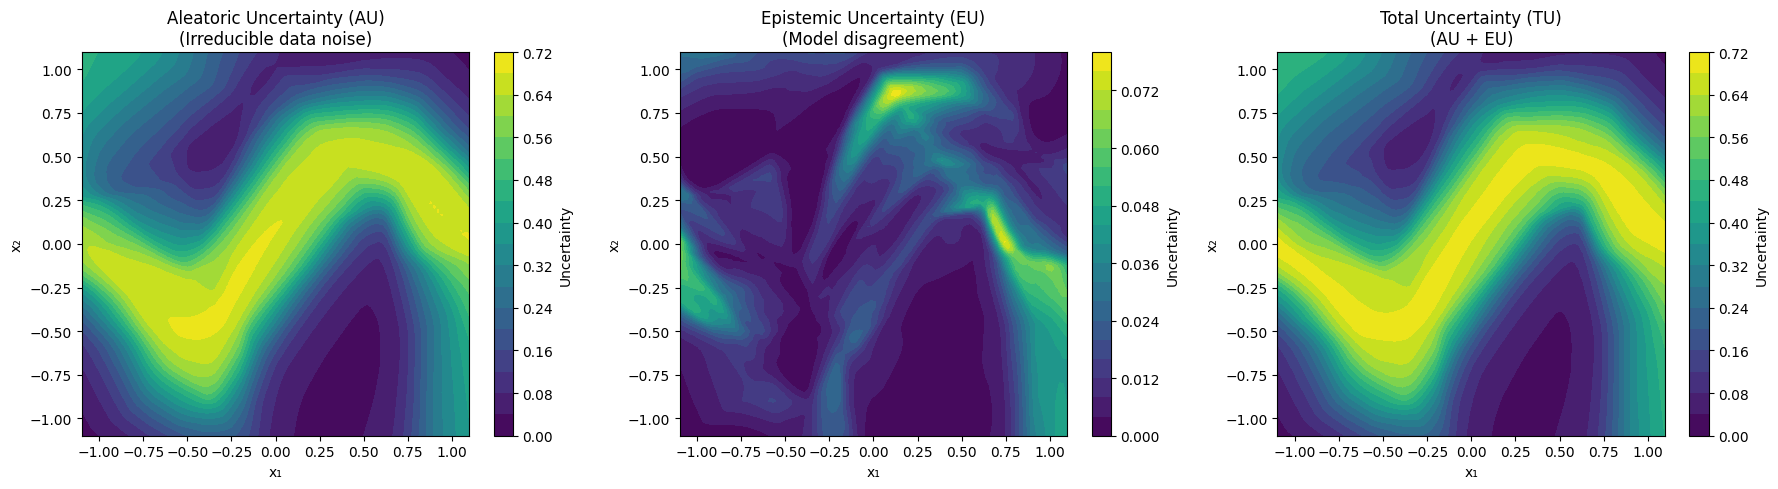

In [24]:
# Plot uncertainty heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Aleatoric uncertainty (inherent data randomness)
plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='aleatoric', ax=axes[0]
)
axes[0].set_title('Aleatoric Uncertainty (AU)\n(Irreducible data noise)')

# Epistemic uncertainty (model uncertainty)
plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='epistemic', ax=axes[1]
)
axes[1].set_title('Epistemic Uncertainty (EU)\n(Model disagreement)')

# Total uncertainty
plot_uncertainty_heatmap(
    ensemble.models, X, device=device,
    uncertainty_type='total', ax=axes[2]
)
axes[2].set_title('Total Uncertainty (TU)\n(AU + EU)')

plt.tight_layout()
plt.show()

## 4. Select a Factual Instance

Choose a point from class 0 that we want to flip to class 1. This is our "factual" instance - the starting point for counterfactual generation.

In [25]:
# Select a factual point from class 0
class_0_indices = np.where(y == 0)[0]
factual_idx = class_0_indices[10]  # Pick one point
factual = X[factual_idx]

# Get model prediction for the factual
factual_t = torch.from_numpy(factual.astype(np.float32)).unsqueeze(0).to(device)
with torch.no_grad():
    probs_factual = ensemble.predict_proba(factual_t)
    pred_class = probs_factual.argmax(dim=1).item()

# Compute uncertainty at factual point
unc = compute_uncertainty_decomposition(ensemble.models, factual, device)

print(f"Factual point: [{factual[0]:.4f}, {factual[1]:.4f}]")
print(f"True class: {y[factual_idx]}")
print(f"Predicted class: {pred_class}")
print(f"P(class=0): {probs_factual[0, 0]:.4f}, P(class=1): {probs_factual[0, 1]:.4f}")
print(f"\nUncertainty at factual:")
print(f"  Aleatoric (AU): {unc.aleatoric:.4f}")
print(f"  Epistemic (EU): {unc.epistemic:.4f}")
print(f"  Total (TU):     {unc.total:.4f}")

Factual point: [0.4005, -0.3753]
True class: 0
Predicted class: 0
P(class=0): 0.9926, P(class=1): 0.0074

Uncertainty at factual:
  Aleatoric (AU): 0.0529
  Epistemic (EU): 0.0029
  Total (TU):     0.0557


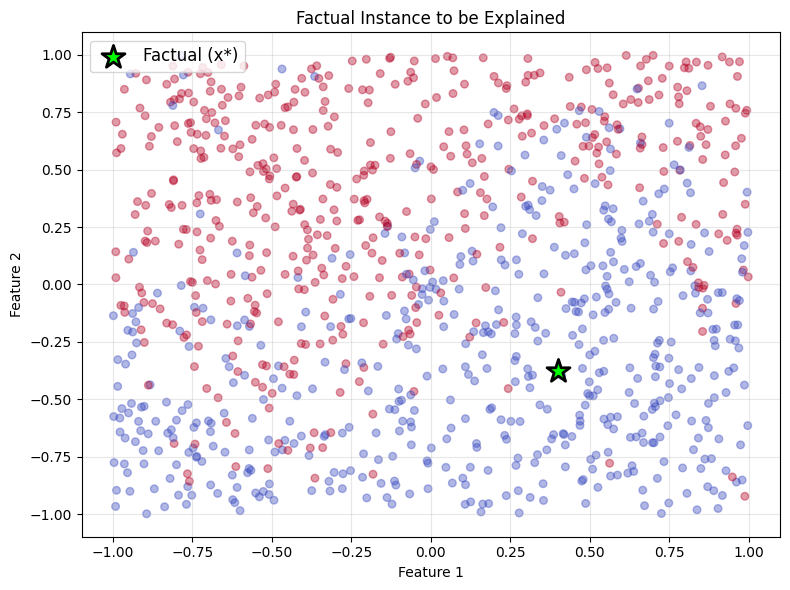

In [26]:
# Visualize the factual point
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.4, s=30)
ax.scatter(factual[0], factual[1], c='lime', s=300, marker='*', 
           edgecolors='black', linewidth=2, label='Factual (x*)', zorder=5)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Factual Instance to be Explained')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Generate Counterfactuals with NSGA-II

Now we use multi-objective optimization to find counterfactuals. The objectives are:

1. **Validity**: Maximize P(target class) - we want the counterfactual to be classified as class 1
2. **Epistemic Uncertainty**: Consider regions of low/high model uncertainty
3. **Sparsity**: Minimize the number of changed features
4. **Aleatoric Uncertainty**: Consider inherent data uncertainty

NSGA-II finds a Pareto front of non-dominated solutions, giving us diverse counterfactual options.

In [27]:
# Configure counterfactual generation
# Note: AU is maximized, EU is minimized (prefer confident regions)
cf_config = CFConfig()

nsga_config = NSGAConfig(
    pop_size=100,    # Population size
    n_gen=50,        # Number of generations
    verbose=True,    # Show progress
)

# Create CF problem
target_class = 1  # We want to flip to class 1

factual_t = torch.from_numpy(factual.astype(np.float32)).to(device)
target_t = torch.tensor([target_class], device=device)
X_t = torch.from_numpy(X.astype(np.float32)).to(device)

problem = make_cf_problem(
    model=ensemble.models[0],
    x_star=factual_t,
    y_target=target_t,
    X_obs=X_t,
    config=cf_config,
    ensemble=ensemble.models,
    device=device,
)

print(f"Problem setup complete:")
print(f"  Variables: {problem.n_var}")
print(f"  Objectives: {problem.n_obj}")
print(f"  Objective order: [Validity, Sparsity, AU (max), EU (min)]")

Problem setup complete:
  Variables: 2
  Objectives: 4
  Objective order: [Validity, Sparsity, AU (max), EU (min)]


In [28]:
# Run NSGA-II optimization
print("Running NSGA-II optimization...\n")
result = run_nsga2(
    problem=problem,
    config=nsga_config,
)

print(f"\n✓ Optimization complete!")
print(f"  Found {len(result.X)} counterfactual candidates")

Running NSGA-II optimization...

Gen    1 | Valid CFs (pop):  51 | Valid CFs (archive):  36 | Best P(target): 0.997 | Mean Sparsity: 1.919
Gen   10 | Valid CFs (pop):  92 | Valid CFs (archive):  92 | Best P(target): 0.998 | Mean Sparsity: 1.820
Gen   20 | Valid CFs (pop):  88 | Valid CFs (archive):  88 | Best P(target): 0.999 | Mean Sparsity: 1.740
Gen   30 | Valid CFs (pop):  87 | Valid CFs (archive):  87 | Best P(target): 0.999 | Mean Sparsity: 1.640
Gen   40 | Valid CFs (pop):  88 | Valid CFs (archive):  88 | Best P(target): 0.999 | Mean Sparsity: 1.580
Gen   50 | Valid CFs (pop):  86 | Valid CFs (archive):  86 | Best P(target): 0.999 | Mean Sparsity: 1.600

✓ Optimization complete!
  Found 100 counterfactual candidates


## 6. Visualize Pareto Front in Objective Space

Since we use multi-objective optimization, all counterfactuals on the Pareto front are non-dominated solutions - none is strictly "better" than another. Let's visualize the Pareto front in 3D objective space to see the trade-offs.

In [29]:
# 3D Pareto Front Visualization in Objective Space (Interactive with Plotly)
import plotly.graph_objects as go

if result.F is not None and len(result.F) > 0:
    # Separate valid and invalid counterfactuals
    # Objectives: [0] Validity (1-P), [1] Sparsity, [2] AU (negated), [3] EU (positive)
    validity = result.F[:, 0]  # 1 - P(target), so < 0.5 means valid
    valid_mask = validity < 0.5
    invalid_mask = ~valid_mask
    
    valid_F = result.F[valid_mask]
    invalid_F = result.F[invalid_mask]
    
    # Evaluate all training data in objective space for context
    F_X = problem.evaluate(X)
    
    # Evaluate factual point in objective space
    F_factual = problem.evaluate(factual.astype(np.float32))
    
    fig = go.Figure()
    
    # Original observations in Obj Space (for context)
    # Use EU (index 3, positive) for x, Validity (index 0) for y, AU (index 2, negated) for z
    fig.add_trace(go.Scatter3d(
        x=F_X[:, 3], y=F_X[:, 0], z=-F_X[:, 2],  # EU is positive, negate AU
        mode='markers',
        marker=dict(color='green', size=3, opacity=0.2),
        name='Original observations in Obj Space'
    ))
    
    # Invalid Pareto front points (blue crosses)
    if len(invalid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=invalid_F[:, 3], y=invalid_F[:, 0], z=-invalid_F[:, 2],
            mode='markers',
            marker=dict(color='blue', size=5, opacity=1, symbol='cross'),
            name=f'Pareto Front - Invalid (n={len(invalid_F)})'
        ))
    
    # Valid counterfactuals (red crosses)
    if len(valid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=valid_F[:, 3], y=valid_F[:, 0], z=-valid_F[:, 2],
            mode='markers',
            marker=dict(color='red', size=5, symbol='cross'),
            name=f'Valid Counterfactuals (n={len(valid_F)})'
        ))
    
    # Factual point (purple)
    fig.add_trace(go.Scatter3d(
        x=[F_factual[3]],
        y=[F_factual[0]],
        z=[-F_factual[2]],
        mode='markers',
        marker=dict(color='purple', size=8),
        name='Factual Instance x* in Obj Space'
    ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Epistemic Uncertainty (minimize)',
            yaxis_title='Invalidity (1-P(target))',
            zaxis_title='Aleatoric Uncertainty (maximize)'
        ),
        width=900, height=700,
        title='Pareto Front in 3D Objective Space (Interactive)'
    )
    
    fig.show()
    
    print(f"\nTotal Pareto-optimal counterfactuals: {len(result.X)}")
    print(f"Valid CFs (P(target) > 0.5): {np.sum(valid_mask)}")
    print(f"Invalid CFs (P(target) ≤ 0.5): {np.sum(invalid_mask)}")


Total Pareto-optimal counterfactuals: 100
Valid CFs (P(target) > 0.5): 86
Invalid CFs (P(target) ≤ 0.5): 14


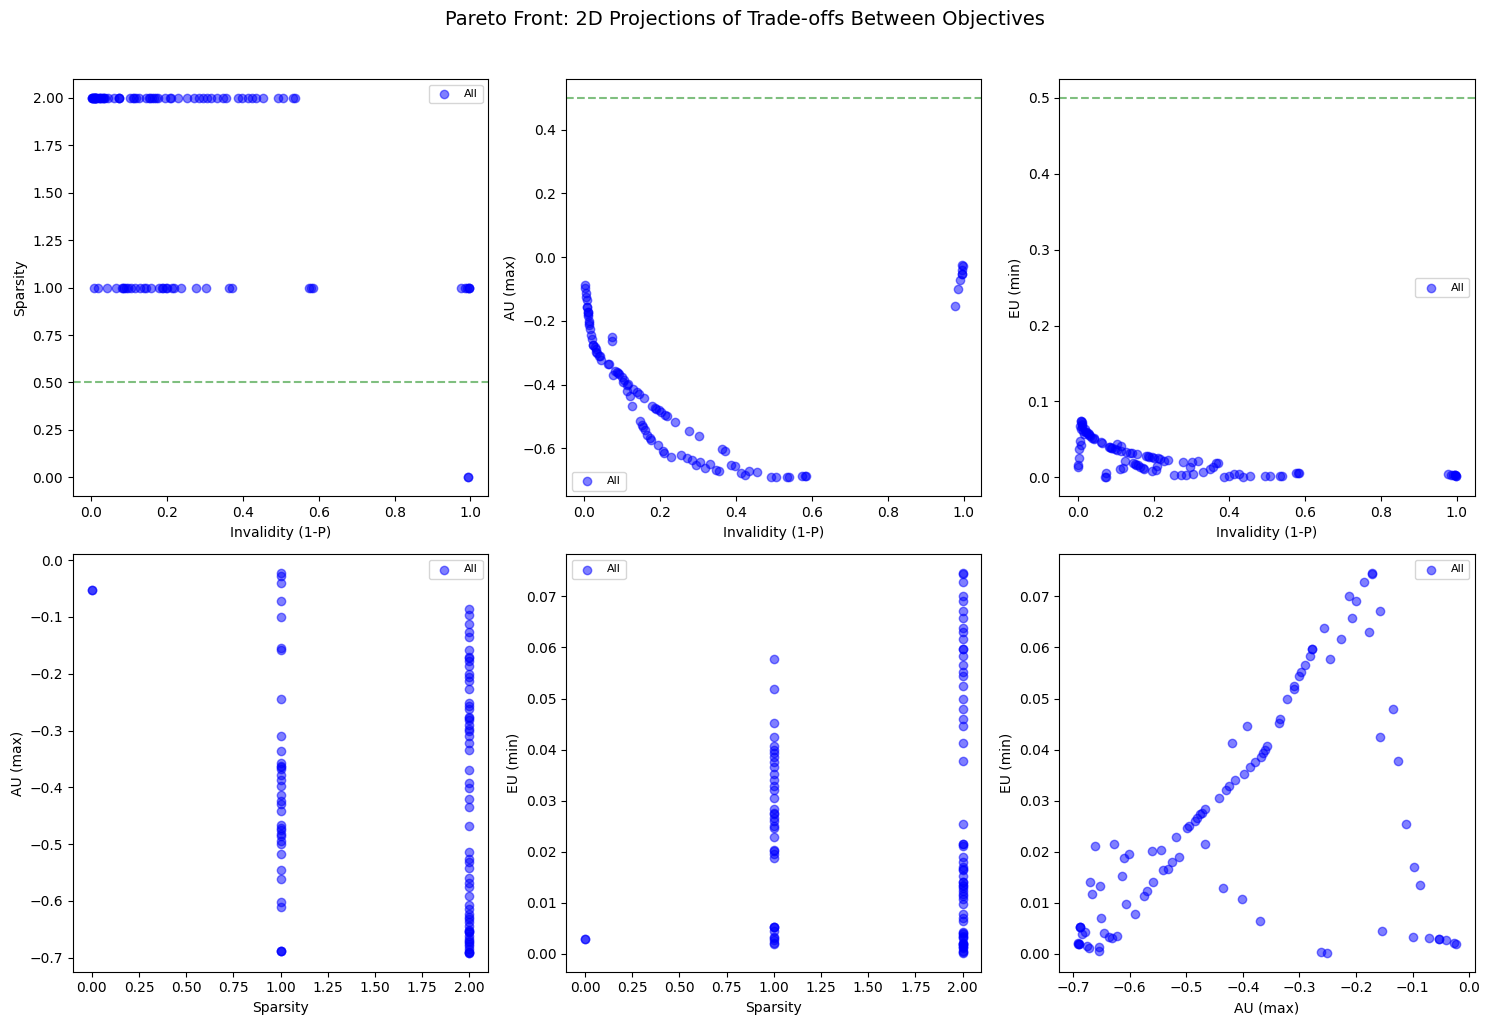

In [30]:
# Visualize Pareto front with different objective combinations (2D projections)
if result.F is not None and len(result.F) > 0:
    fig, axes = plot_pareto_front_2d(
        result.F,
        objective_names=['Invalidity (1-P)', 'Sparsity', 'AU (max)', 'EU (min)'],
    )
    fig.suptitle('Pareto Front: 2D Projections of Trade-offs Between Objectives', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## 7. Counterfactuals in Feature Space with Decision Boundary

Now let's visualize all Pareto-optimal counterfactuals in the 2D feature space, overlaid on the model's decision boundary. We distinguish between:
- **Valid counterfactuals** (green): P(target class) > 0.5 - successfully flipped to target class
- **Invalid counterfactuals** (red): P(target class) ≤ 0.5 - not yet flipped but may have other desirable properties (low uncertainty, etc.)

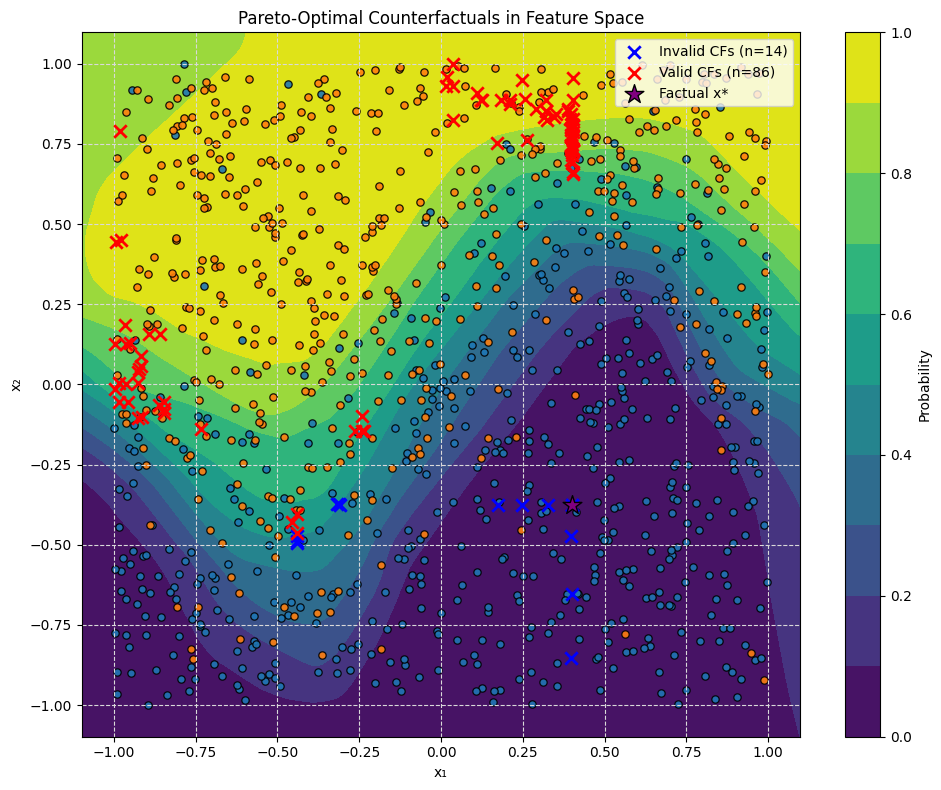


Summary:
  Factual point: [0.4005, -0.3753] - Class 0
  Target class: 1
  Total Pareto-optimal CFs: 100
  Valid CFs (flipped to target): 86
  Invalid CFs (not yet flipped): 14


In [31]:
# Feature Space: Counterfactuals on Decision Boundary Background
fig, ax = plt.subplots(figsize=(10, 8))

# Use plot_proba for the decision boundary background
plot_proba(ensemble, X, y, grid_resolution=150, ax=ax, device=device,levels=10)

# Separate valid and invalid counterfactuals
validity = result.F[:, 0]  # 1 - P(target), so < 0.5 means valid
valid_mask = validity < 0.5
invalid_mask = ~valid_mask

valid_cfs = result.X[valid_mask]
invalid_cfs = result.X[invalid_mask]

# Scatter invalid counterfactuals (blue crosses)
if len(invalid_cfs) > 0:
    ax.scatter(
        invalid_cfs[:, 0], invalid_cfs[:, 1],
        c='blue', s=80, marker='x', linewidths=2,
        label=f'Invalid CFs (n={len(invalid_cfs)})', zorder=6
    )

# Scatter valid counterfactuals (red crosses)
if len(valid_cfs) > 0:
    ax.scatter(
        valid_cfs[:, 0], valid_cfs[:, 1],
        c='red', s=80, marker='x', linewidths=2,
        label=f'Valid CFs (n={len(valid_cfs)})', zorder=7
    )

# Scatter factual point (purple star)
ax.scatter(
    factual[0], factual[1],
    c='purple', s=200, marker='*',
    edgecolors='black', linewidth=1,
    label='Factual x*', zorder=10
)

ax.set_title('Pareto-Optimal Counterfactuals in Feature Space')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Factual point: [{factual[0]:.4f}, {factual[1]:.4f}] - Class {y[factual_idx]}")
print(f"  Target class: {target_class}")
print(f"  Total Pareto-optimal CFs: {len(result.X)}")
print(f"  Valid CFs (flipped to target): {len(valid_cfs)}")
print(f"  Invalid CFs (not yet flipped): {len(invalid_cfs)}")

## 8. Pareto Front Statistics

Let's examine the properties of the Pareto-optimal counterfactuals. Remember: all these points are non-dominated, meaning no single CF is strictly better than another across all objectives.

In [ ]:
# Pareto Front Statistics
print("Pareto Front Statistics")
print("=" * 70)

obj_names = ['Invalidity (1-P)', 'Epistemic U.', 'Sparsity', 'Aleatoric U.']

print(f"\n{'Objective':<25} {'Min':>12} {'Max':>12} {'Mean':>12} {'Std':>12}")
print("-" * 70)
for i, name in enumerate(obj_names):
    vals = result.F[:, i]
    print(f"{name:<25} {vals.min():>12.4f} {vals.max():>12.4f} {vals.mean():>12.4f} {vals.std():>12.4f}")

# Compute distances from factual
distances = np.linalg.norm(result.X - factual, axis=1)

print(f"\n{'Distance from Factual':<25} {distances.min():>12.4f} {distances.max():>12.4f} {distances.mean():>12.4f} {distances.std():>12.4f}")

# Sample 5 diverse counterfactuals from different parts of Pareto front
print("\n\nSample of 5 Diverse Pareto-Optimal Counterfactuals:")
print("=" * 70)

# Select CFs with diverse trade-offs: best validity, best EU, best sparsity, etc.
sample_indices = []
for obj_idx in range(min(4, result.F.shape[1])):
    best_for_obj = np.argmin(result.F[:, obj_idx])
    if best_for_obj not in sample_indices:
        sample_indices.append(best_for_obj)

# Add one random valid CF if we have room
if len(sample_indices) < 5:
    valid_indices = np.where(result.F[:, 0] < 0.5)[0]
    if len(valid_indices) > 0:
        rand_valid = np.random.choice(valid_indices)
        if rand_valid not in sample_indices:
            sample_indices.append(rand_valid)

for i, idx in enumerate(sample_indices[:5]):
    cf = result.X[idx]
    cf_t = torch.from_numpy(cf.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        probs_cf = ensemble.predict_proba(cf_t)
    
    unc_cf = compute_uncertainty_decomposition(ensemble.models, cf, device)
    dist = np.linalg.norm(cf - factual)
    is_valid = "✓ Valid" if result.F[idx, 0] < 0.5 else "✗ Invalid"
    
    print(f"\nCF #{i+1} [{cf[0]:.3f}, {cf[1]:.3f}] - {is_valid}")
    print(f"    P(target={target_class}): {probs_cf[0, target_class]:.4f}")
    print(f"    Distance: {dist:.4f}")
    print(f"    AU: {unc_cf.aleatoric:.4f}, EU: {unc_cf.epistemic:.4f}")

Pareto Front Statistics

Objective                          Min          Max         Mean          Std
----------------------------------------------------------------------
Invalidity (1-P)                0.0014       0.9970       0.2449       0.2687
Epistemic U.                    0.0000       2.0000       1.6000       0.5292
Sparsity                       -0.6912      -0.0235      -0.4126       0.2022
Aleatoric U.                    0.0002       0.0745       0.0264       0.0221

Distance from Factual           0.0005       1.8086       1.1183       0.3545


Sample of 5 Diverse Pareto-Optimal Counterfactuals:

CF #1 [0.038, 0.998] - ✓ Valid
    P(target=1): 0.9909
    Distance: 1.4205
    AU: 0.0860, EU: 0.0135

CF #2 [0.400, -0.375] - ✗ Invalid
    P(target=1): 0.0074
    Distance: 0.0005
    AU: 0.0530, EU: 0.0029

CF #3 [-0.441, -0.472] - ✗ Invalid
    P(target=1): 0.5006
    Distance: 0.8471
    AU: 0.6912, EU: 0.0019

CF #4 [-0.977, 0.449] - ✓ Valid
    P(target=1): 0.9307
    D

: 

## Summary

This demo showed how to:

1. **Generate synthetic data** with configurable probability surfaces
2. **Train a deep ensemble** for uncertainty-aware predictions
3. **Visualize decision boundaries** and uncertainty decomposition (AU/EU/TU)
4. **Generate counterfactuals** using NSGA-II multi-objective optimization
5. **Visualize the Pareto front** in 3D objective space and 2D feature space

### Key Insights

- **Pareto Front**: All generated counterfactuals are non-dominated - no single CF is strictly "better" than another across all objectives. Users choose based on their priorities.

- **Valid vs Invalid CFs**: 
  - **Valid (green)**: P(target) > 0.5 - successfully flipped to target class
  - **Invalid (red)**: P(target) ≤ 0.5 - not flipped, but may have desirable uncertainty properties

- **Trade-offs**: The Pareto front reveals inherent trade-offs:
  - Validity vs. Distance (closer CFs may not flip the class)
  - Validity vs. Epistemic Uncertainty (confident predictions may be far from factual)
  - Aleatoric vs. Epistemic (different types of uncertainty)

- **Decision Boundary Context**: Visualizing CFs on the decision boundary helps understand why some are valid and others aren't.